In [ ]:
import requests                  #A library used to make HTTP requests.
import zipfile                   #A module to work with ZIP files.
from pathlib import Path         #A class for handling filesystem paths in a more convenient way.

# Setup path to data folder
data_path = Path("data/")        #defining  a base directory
image_path = data_path / "pizzasteak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)                          #making a directory

    # Downloading the zip file containing Train and Test folders:
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f: #The name"pizza_steak_sushi" is an arbitrary name that we choose(not related to the original folder data we want to download). the data will be downloaded as this name under "pizzasteak_sushi" folder.
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")

        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)


    # Unzip pizza, steak, sushi data
    #it opens the ZIP file using zipfile.ZipFile and extracts its contents into the image_path directory using zip_ref.extractall(image_path).

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizzasteak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizzasteak_sushi'.
There are 3 directories and 0 images in 'data/pizzasteak_sushi/test'.
There are 0 directories and 31 images in 'data/pizzasteak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizzasteak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizzasteak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizzasteak_sushi/train'.
There are 0 directories and 72 images in 'data/pizzasteak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizzasteak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizzasteak_sushi/train/pizza'.


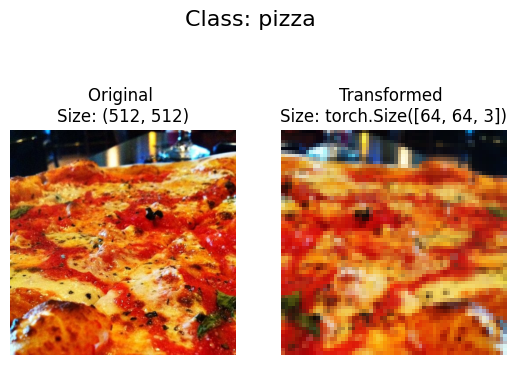

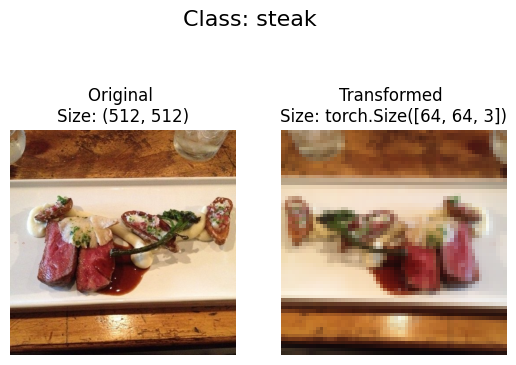

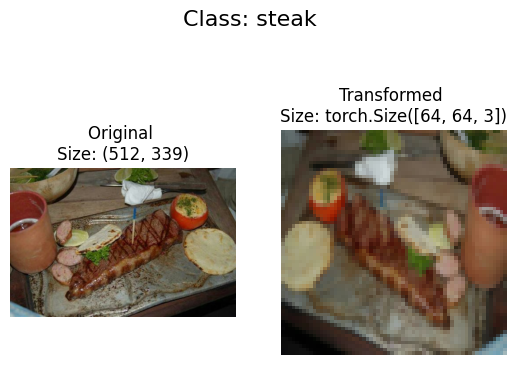

In [ ]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [ ]:
# OUR OWN CLASS

from torch.utils.data import Dataset

class custom_Imagfolder(Dataset):
  def __init__(self,targ_dir,transform=None):
    self.path=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform=transform
    self.classes , self.class_to_idx = findclassess(targ_dir)

 #Make function to load images : "Opens an image via a path and returns it."
  def load_image(self,index):
    image_path=self.path[index]
    return Image.open(image_path)

  #5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
  def __len__(self):
    "Returns the total number of samples."
    return len(self.path)

  # Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
  #Now you might think that how is it different from the built-in indexer [] operator? Wherever you use this notation, python automatically calls the __getitem__ method for you and is the shorthand for accessing elements. But if you want to change the behavior of indexing for custom objects, you need to explicitly call the __getitem__ method.
  def __getitem__(self,idx:int):
    img = self.load_image(idx)
    class_name  = self.path[idx].parent.name # expects path in data_folder/class_name/image.jpeg
    class_idx = self.class_to_idx[class_name]
    # Transform if necessary
    if self.transform:
        return self.transform(img), class_idx # return data, label (X, y)
    else:
        return img, class_idx # return data, label (X, y)


In [ ]:
#making transforms to be used when creating train data with our own custom dataset. this transform will be used as one of the arguments for the class.
train_transforms=transforms.Compose([transforms.Resize((64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

# Don't augment test data, only reshape
test_transforms=transforms.Compose([transforms.Resize((64,64)),
                                     transforms.ToTensor()])

In [ ]:
train_data_custom = custom_Imagfolder(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = custom_Imagfolder(targ_dir=test_dir,
                                     transform=test_transforms)

Target directory: data/pizzasteak_sushi/train
Target directory: data/pizzasteak_sushi/test


In [ ]:
from torch import nn
class CNN_custom(nn.Module):
  def __init__(self,input_features:int,hidden_neurons:int,output_features:int):
    super().__init__()
    self.block1=nn.Sequential(nn.Conv2d(in_channels=input_features, out_channels=hidden_neurons, kernel_size=2,stride=1, padding=1), nn.ReLU(), nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=2,stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2,stride=2))

    self.block2=nn.Sequential(nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=2,stride=1, padding=1), nn.ReLU(), nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=2,stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2,stride=2))

    self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(in_features=hidden_neurons*17*17 ,out_features=output_features))
  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.classifier(x)
    return x


In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [ ]:
summary(Model_CNN_custom, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
CNN_custom                               [1, 3]                    --
├─Sequential: 1-1                        [1, 16, 33, 33]           --
│    └─Conv2d: 2-1                       [1, 16, 65, 65]           208
│    └─ReLU: 2-2                         [1, 16, 65, 65]           --
│    └─Conv2d: 2-3                       [1, 16, 66, 66]           1,040
│    └─ReLU: 2-4                         [1, 16, 66, 66]           --
│    └─MaxPool2d: 2-5                    [1, 16, 33, 33]           --
├─Sequential: 1-2                        [1, 16, 17, 17]           --
│    └─Conv2d: 2-6                       [1, 16, 34, 34]           1,040
│    └─ReLU: 2-7                         [1, 16, 34, 34]           --
│    └─Conv2d: 2-8                       [1, 16, 35, 35]           1,040
│    └─ReLU: 2-9                         [1, 16, 35, 35]           --
│    └─MaxPool2d: 2-10                   [1, 16, 17, 17]           --
├─Seq

In [ ]:
from torch.utils.data import DataLoader
BatchSize=32
train_batches=DataLoader(train_data_custom,BatchSize,shuffle=True)
test_batches=DataLoader(test_data_custom,BatchSize,shuffle=True)

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_batches))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
Model_CNN_custom.eval()
with torch.inference_mode():
    pred = Model_CNN_custom(img_single)

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[-0.0073, -0.0290, -0.0343]])

Output prediction probabilities:
tensor([[0.3388, 0.3315, 0.3297]])

Output prediction label:
tensor([0])

Actual label:
0


In [ ]:
# Optimizer and Loss function

loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some contexts

optimizer = torch.optim.Adam(params=Model_CNN_custom.parameters(), lr=0.001)

In [ ]:
# accuracy function:
def acc_fn(output,target):
 correct = torch.eq(target, output).sum().item() # torch.eq() calculates where two tensors are equal
 acc = (correct / len(output)) * 100
 return acc

In [ ]:
# functionizing the training loop for batches of data in one epoch

def train_step(model,Train_batches,loss_fn,optimizer,acc_fn):  #the way it is defined in the course: def train_step(model: torch.nn.Module,data_loader: torch.utils.data.DataLoader,loss_fn: torch.nn.Module,optimizer: torch.optim.Optimizer,accuracy_fn,):  >>>> in this way it defines the types of variables too

  Train_Loss, Trainaccuracy= 0, 0
  for batch_idx, (X,y) in enumerate(Train_batches):
    model.train()
    y_pred=model(X)
    tr_loss=loss_fn(y_pred,y)
    Train_Loss+=tr_loss

    optimizer.zero_grad()
    tr_loss.backward()
    optimizer.step()
    y_predtrainacc=torch.softmax(y_pred,dim=1).argmax(dim=1)
    Train_acc=acc_fn(y_predtrainacc,y)
    Trainaccuracy+=Train_acc

  Train_Loss /= len(Train_batches)
  Trainaccuracy /= len(Train_batches)
  return Train_Loss, Trainaccuracy


# functionizing the testing loop for batches of data in one epoch

def test_step(model,Test_batches,loss_fn,acc_fn):
  Test_Loss, Testaccuracy = 0, 0

  model.eval()
  with torch.inference_mode():
    for batch_idx, (X,y) in enumerate(Test_batches):
      y_predtest=model(X)
      tst_loss=loss_fn(y_predtest,y)
      Test_Loss+=tst_loss
      y_predtestacc=torch.softmax(y_predtest,dim=1).argmax(dim=1)
      Test_acc=acc_fn(y_predtestacc,y)
      Testaccuracy+=Test_acc

    Test_Loss /= len(Test_batches)
    Testaccuracy /= len(Test_batches)
    return Test_Loss, Testaccuracy


In [ ]:
Epoch=30
#torch.manual_seed(42)
from tqdm.auto import tqdm
### for plotting Loss/accuracy curves
Trloss=[]
Tracc=[]
Tsloss=[]
Tsacc=[]
####
for epoch in tqdm(range(Epoch)):
  #print(f"epoch {epoch} : \n----------")
  Train_loss, Train_accuracy=train_step(Model_CNN_custom,train_batches,loss_fn,optimizer,acc_fn)
  Test_loss, Test_accuracy=test_step(Model_CNN_custom,test_batches,loss_fn,acc_fn)
  #print(f"Train Loss is: {Train_loss} | Train accuracy is: {Train_accuracy} | Test Loss is: {Test_loss} | Test accuracy is: {Test_accuracy}")

  Trloss.append(Train_loss)
  Tracc.append(Train_accuracy)
  Tsloss.append(Test_loss)
  Tsacc.append(Test_accuracy)



  0%|          | 0/30 [00:00<?, ?it/s]

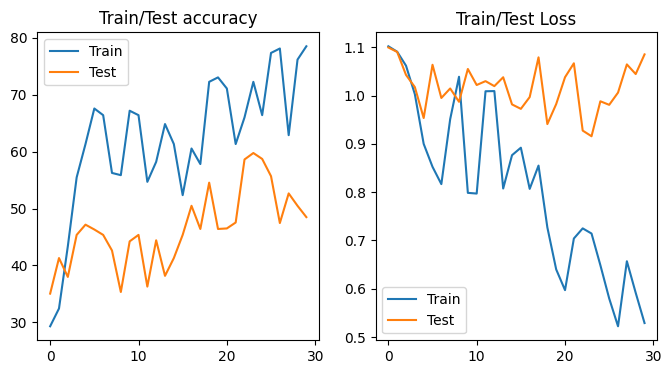

In [ ]:
# for #Epochs=30 and hidden neurons=30
Trlossnum=[t.item() for t in Trloss]
Tslossnum=[t.item() for t in Tsloss]


import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(Tracc,label='Train')
plt.plot(Tsacc,label='Test')
plt.legend()
plt.title("Train/Test accuracy")
plt.subplot(1,2,2)

plt.plot(Trlossnum,label='Train')
plt.plot(Tslossnum,label='Test')
plt.title("Train/Test Loss")
plt.legend()

In [ ]:
#Showing as a Table
import pandas as pd
pd.DataFrame({'Train accuracy':Tracc,'Test accuracy':Tsacc,'Train Loss':Trlossnum,'Test Loss':Tslossnum})

,Train accuracy,Test accuracy,Train Loss,Test Loss
0,33.203125,32.007576,1.120697,1.103114
1,41.406250,43.371212,1.081027,1.071805
2,36.718750,50.378788,1.077875,1.035078
3,45.703125,38.162879,0.999023,1.022722
4,47.265625,42.140152,1.174988,1.000789
5,59.375000,46.401515,0.867370,0.985356
6,60.937500,51.420455,0.907568,0.958597
7,51.953125,38.162879,0.953967,1.019371
8,64.062500,45.359848,0.809897,1.075138
9,66.406250,43.371212,0.842079,1.016930


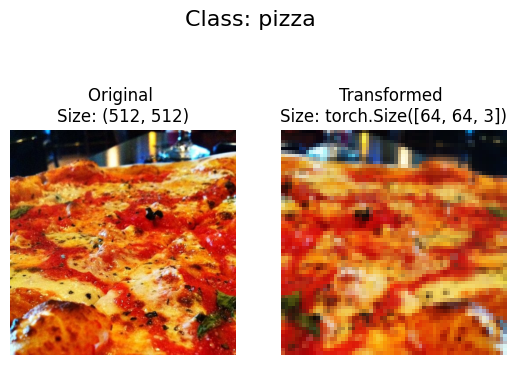

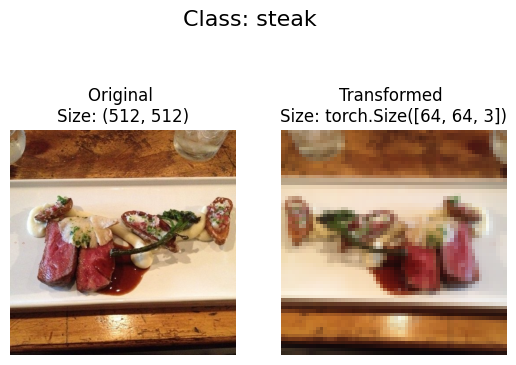

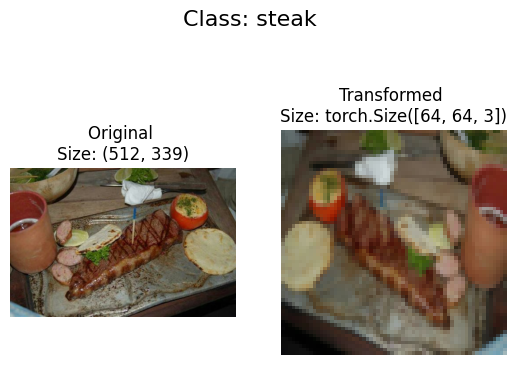

In [ ]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [ ]:
# OUR OWN CLASS

from torch.utils.data import Dataset

class custom_Imagfolder(Dataset):
  def __init__(self,targ_dir,transform=None):
    self.path=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform=transform
    self.classes , self.class_to_idx = findclassess(targ_dir)

 #Make function to load images : "Opens an image via a path and returns it."
  def load_image(self,index):
    image_path=self.path[index]
    return Image.open(image_path)

  #5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
  def __len__(self):
    "Returns the total number of samples."
    return len(self.path)

  # Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
  #Now you might think that how is it different from the built-in indexer [] operator? Wherever you use this notation, python automatically calls the __getitem__ method for you and is the shorthand for accessing elements. But if you want to change the behavior of indexing for custom objects, you need to explicitly call the __getitem__ method.
  def __getitem__(self,idx:int):
    img = self.load_image(idx)
    class_name  = self.path[idx].parent.name # expects path in data_folder/class_name/image.jpeg
    class_idx = self.class_to_idx[class_name]
    # Transform if necessary
    if self.transform:
        return self.transform(img), class_idx # return data, label (X, y)
    else:
        return img, class_idx # return data, label (X, y)


In [ ]:
#making transforms to be used when creating train data with our own custom dataset. this transform will be used as one of the arguments for the class.
train_transforms=transforms.Compose([transforms.Resize((64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

# Don't augment test data, only reshape
test_transforms=transforms.Compose([transforms.Resize((64,64)),
                                     transforms.ToTensor()])

In [ ]:
train_data_custom = custom_Imagfolder(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = custom_Imagfolder(targ_dir=test_dir,
                                     transform=test_transforms)

Target directory: data/pizzasteak_sushi/train
Target directory: data/pizzasteak_sushi/test


In [ ]:
from torch import nn
class CNN_custom(nn.Module):
  def __init__(self,input_features:int,hidden_neurons:int,output_features:int):
    super().__init__()
    self.block1=nn.Sequential(nn.Conv2d(in_channels=input_features, out_channels=hidden_neurons, kernel_size=2,stride=1, padding=1), nn.ReLU(), nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=2,stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2,stride=2))

    self.block2=nn.Sequential(nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=2,stride=1, padding=1), nn.ReLU(), nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=2,stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2,stride=2))

    self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(in_features=hidden_neurons*17*17 ,out_features=output_features))
  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.classifier(x)
    return x


In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [ ]:
summary(Model_CNN_custom, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
CNN_custom                               [1, 3]                    --
├─Sequential: 1-1                        [1, 16, 33, 33]           --
│    └─Conv2d: 2-1                       [1, 16, 65, 65]           208
│    └─ReLU: 2-2                         [1, 16, 65, 65]           --
│    └─Conv2d: 2-3                       [1, 16, 66, 66]           1,040
│    └─ReLU: 2-4                         [1, 16, 66, 66]           --
│    └─MaxPool2d: 2-5                    [1, 16, 33, 33]           --
├─Sequential: 1-2                        [1, 16, 17, 17]           --
│    └─Conv2d: 2-6                       [1, 16, 34, 34]           1,040
│    └─ReLU: 2-7                         [1, 16, 34, 34]           --
│    └─Conv2d: 2-8                       [1, 16, 35, 35]           1,040
│    └─ReLU: 2-9                         [1, 16, 35, 35]           --
│    └─MaxPool2d: 2-10                   [1, 16, 17, 17]           --
├─Seq

In [ ]:
from torch.utils.data import DataLoader
BatchSize=32
train_batches=DataLoader(train_data_custom,BatchSize,shuffle=True)
test_batches=DataLoader(test_data_custom,BatchSize,shuffle=True)

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_batches))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
Model_CNN_custom.eval()
with torch.inference_mode():
    pred = Model_CNN_custom(img_single)

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[-0.0073, -0.0290, -0.0343]])

Output prediction probabilities:
tensor([[0.3388, 0.3315, 0.3297]])

Output prediction label:
tensor([0])

Actual label:
0


In [ ]:
# Optimizer and Loss function

loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some contexts

optimizer = torch.optim.Adam(params=Model_CNN_custom.parameters(), lr=0.001)

In [ ]:
# accuracy function:
def acc_fn(output,target):
 correct = torch.eq(target, output).sum().item() # torch.eq() calculates where two tensors are equal
 acc = (correct / len(output)) * 100
 return acc

In [ ]:
# functionizing the training loop for batches of data in one epoch

def train_step(model,Train_batches,loss_fn,optimizer,acc_fn):  #the way it is defined in the course: def train_step(model: torch.nn.Module,data_loader: torch.utils.data.DataLoader,loss_fn: torch.nn.Module,optimizer: torch.optim.Optimizer,accuracy_fn,):  >>>> in this way it defines the types of variables too

  Train_Loss, Trainaccuracy= 0, 0
  for batch_idx, (X,y) in enumerate(Train_batches):
    model.train()
    y_pred=model(X)
    tr_loss=loss_fn(y_pred,y)
    Train_Loss+=tr_loss

    optimizer.zero_grad()
    tr_loss.backward()
    optimizer.step()
    y_predtrainacc=torch.softmax(y_pred,dim=1).argmax(dim=1)
    Train_acc=acc_fn(y_predtrainacc,y)
    Trainaccuracy+=Train_acc

  Train_Loss /= len(Train_batches)
  Trainaccuracy /= len(Train_batches)
  return Train_Loss, Trainaccuracy


# functionizing the testing loop for batches of data in one epoch

def test_step(model,Test_batches,loss_fn,acc_fn):
  Test_Loss, Testaccuracy = 0, 0

  model.eval()
  with torch.inference_mode():
    for batch_idx, (X,y) in enumerate(Test_batches):
      y_predtest=model(X)
      tst_loss=loss_fn(y_predtest,y)
      Test_Loss+=tst_loss
      y_predtestacc=torch.softmax(y_predtest,dim=1).argmax(dim=1)
      Test_acc=acc_fn(y_predtestacc,y)
      Testaccuracy+=Test_acc

    Test_Loss /= len(Test_batches)
    Testaccuracy /= len(Test_batches)
    return Test_Loss, Testaccuracy


In [ ]:
Epoch=30
#torch.manual_seed(42)
from tqdm.auto import tqdm
### for plotting Loss/accuracy curves
Trloss=[]
Tracc=[]
Tsloss=[]
Tsacc=[]
####
for epoch in tqdm(range(Epoch)):
  #print(f"epoch {epoch} : \n----------")
  Train_loss, Train_accuracy=train_step(Model_CNN_custom,train_batches,loss_fn,optimizer,acc_fn)
  Test_loss, Test_accuracy=test_step(Model_CNN_custom,test_batches,loss_fn,acc_fn)
  #print(f"Train Loss is: {Train_loss} | Train accuracy is: {Train_accuracy} | Test Loss is: {Test_loss} | Test accuracy is: {Test_accuracy}")

  Trloss.append(Train_loss)
  Tracc.append(Train_accuracy)
  Tsloss.append(Test_loss)
  Tsacc.append(Test_accuracy)



  0%|          | 0/30 [00:00<?, ?it/s]

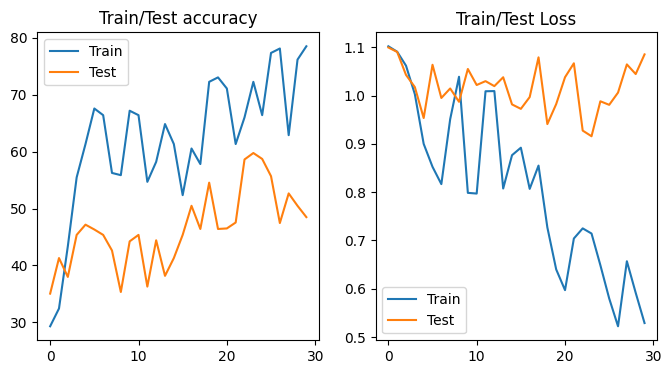

In [ ]:
# for #Epochs=30 and hidden neurons=30
Trlossnum=[t.item() for t in Trloss]
Tslossnum=[t.item() for t in Tsloss]


import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(Tracc,label='Train')
plt.plot(Tsacc,label='Test')
plt.legend()
plt.title("Train/Test accuracy")
plt.subplot(1,2,2)

plt.plot(Trlossnum,label='Train')
plt.plot(Tslossnum,label='Test')
plt.title("Train/Test Loss")
plt.legend()

In [ ]:
#Showing as a Table
import pandas as pd
pd.DataFrame({'Train accuracy':Tracc,'Test accuracy':Tsacc,'Train Loss':Trlossnum,'Test Loss':Tslossnum})

,Train accuracy,Test accuracy,Train Loss,Test Loss
0,33.203125,32.007576,1.120697,1.103114
1,41.406250,43.371212,1.081027,1.071805
2,36.718750,50.378788,1.077875,1.035078
3,45.703125,38.162879,0.999023,1.022722
4,47.265625,42.140152,1.174988,1.000789
5,59.375000,46.401515,0.867370,0.985356
6,60.937500,51.420455,0.907568,0.958597
7,51.953125,38.162879,0.953967,1.019371
8,64.062500,45.359848,0.809897,1.075138
9,66.406250,43.371212,0.842079,1.016930
